In [1]:
import collections

# load image data
import os
import string
import time
from collections import Counter

import cv2
import imageio  # use imread function to read the image

# visualization libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.callbacks import History
from PIL import Image
from sklearn.metrics import classification_report
import sklearn.model_selection as model_selection
from tensorflow import keras
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import initializers, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    BatchNormalization,
    Bidirectional,
    Conv2D,
    Dense,
    Input,
    Lambda,
    MaxPool2D,
    Reshape,
)
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.python.keras.utils.layer_utils import count_params
from tqdm import tqdm
from pathlib import Path

2023-10-16 04:46:51.709887: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 04:46:51.709972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 04:46:51.710148: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-16 04:46:51.737377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import tools and libraries

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


np.random.seed(42)
tf.random.set_seed(42)

### GTSRB - German Traffic Sign Recognition Benchmark Dataset

### Data source: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?select=Train.csv

### Open the label file (labels-map-proj-v3.txt) and get the lable lines

### Get Labels Data

In [3]:
# load the labels from the test Excel file in the sign_data folder
from process_raw_dataset import get_test_df, get_train_df, get_meta_df, store_exists

# open the train Excel file in the sign_data folder
if store_exists():
    train_classid = get_train_df()
    test_classid = get_test_df()
    meta_df = get_meta_df()
else:
    train_classid = get_train_df(create_cache=True)
    test_classid = get_test_df(create_cache=True)
    meta_df = get_meta_df(create_cache=True)


# define a function to get the class id and path of the train images into a list


def get_id_path(filename):
    image_path = []
    class_id = []
    for i in tqdm(range(len(filename))):
        image_path.append(filename.iloc[i, 7])
        class_id.append(filename.iloc[i, 6])
    return image_path, class_id


train_image_path, train_class_id = get_id_path(train_classid)
test_image_path, test_class_id = get_id_path(test_classid)

print("Total number of train images: ", len(train_image_path))
print("Total number of train class ids: ", len(train_class_id))
print("Total number of test images: ", len(test_image_path))
print("Total number of test class ids: ", len(test_class_id))

print(train_image_path[:2], train_class_id[:2])

/opt/python/py311/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/python/py311/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/python/py311/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tf/notebooks/281-final-project/process_raw_dataset.py:76: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['Path', 'Numpy', 'Bytesio'], dtype='obj

Total number of train images:  39209
Total number of train class ids:  39209
Total number of test images:  12630
Total number of test class ids:  12630
['/tf/notebooks/281-final-project/sign_data/Train/20/00020_00000_00000.png', '/tf/notebooks/281-final-project/sign_data/Train/20/00020_00000_00001.png'] [20, 20]


In [4]:
# check for duplicates

duplicate_list_train = [
    item for item, count in collections.Counter(train_image_path).items() if count > 1
]
test_counts = test_classid.groupby(["Path"], as_index=False).size()

print("Duplicate size:", test_counts[test_counts["size"] != 1]["Path"].shape)

duplicate_list_test = [
    item for item, count in collections.Counter(test_image_path).items() if count > 1
]
train_counts = train_classid.groupby(["Path"], as_index=False).size()
print("Duplicate size:", train_counts[train_counts["size"] != 1]["Path"].shape)

Duplicate size: (0,)
Duplicate size: (0,)


In [5]:
# select one sample of each class id in the train_class_id list and find the corresponding image path

unique_class_id = np.unique(train_class_id)
print("Unique class id: ", unique_class_id)
unique_class_id_path = []
for i in tqdm(range(len(unique_class_id))):
    for j in range(len(train_class_id)):
        if unique_class_id[i] == train_class_id[j]:
            unique_class_id_path.append(train_image_path[j])
            break
print("Total number of unique class id: ", len(unique_class_id_path))

Unique class id:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


100%|██████████| 43/43 [00:00<00:00, 197.90it/s]

Total number of unique class id:  43


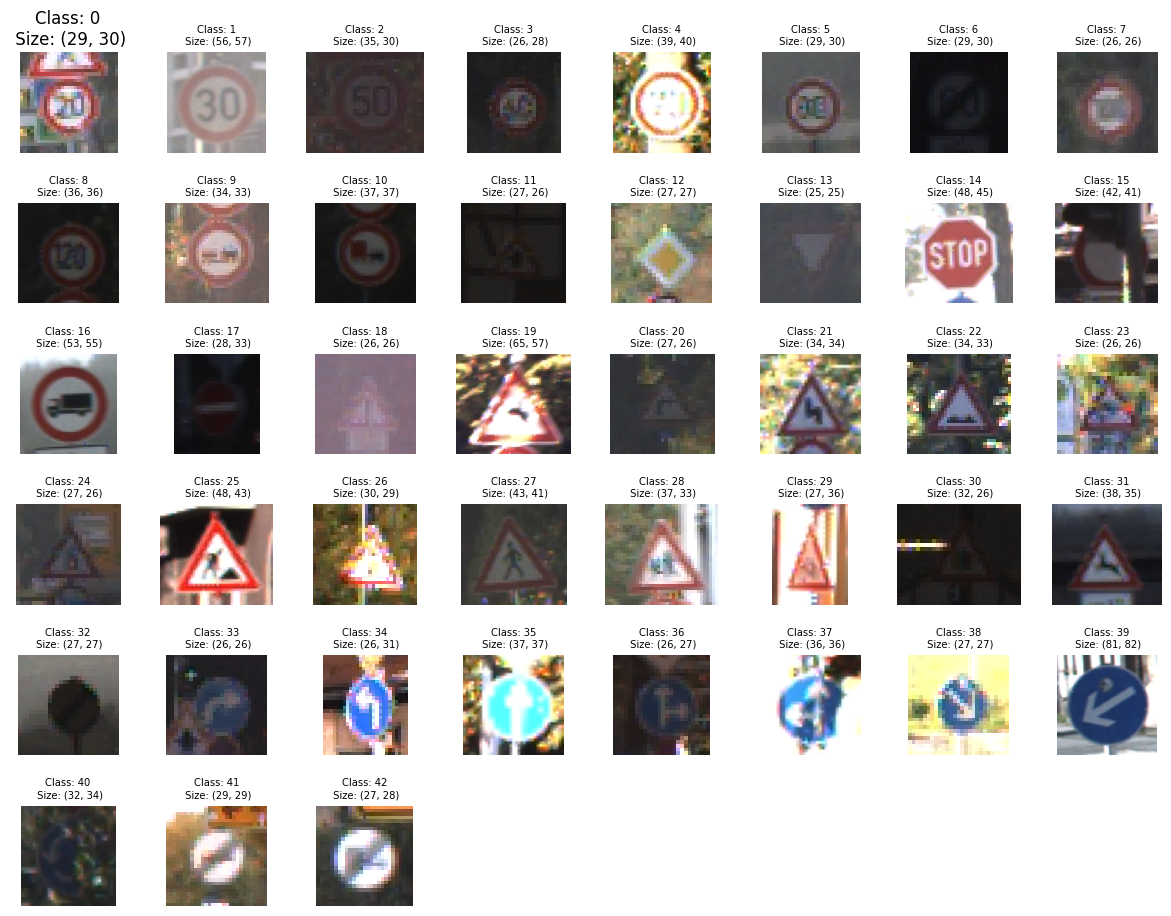

In [6]:
# show the images of the unique class id
plt.figure(figsize=(15, 15))
for i in range(len(unique_class_id_path)):
    plt.subplot(8, 8, i + 1)
    plt.imshow(Image.open(unique_class_id_path[i]))
    plt.title(unique_class_id[i])
    plt.axis("off")
    plt.subplots_adjust(hspace=0.5)
    # split the title into two lines
    plt.title(
        "Class: "
        + str(unique_class_id[i])
        + "\n Size: "
        + str(Image.open(unique_class_id_path[i]).size)
    )

    # change the fond size of the title
    plt.rcParams.update({"font.size": 6})


plt.show()

Text(0.5, 1.0, 'Distribution of Test Classes')

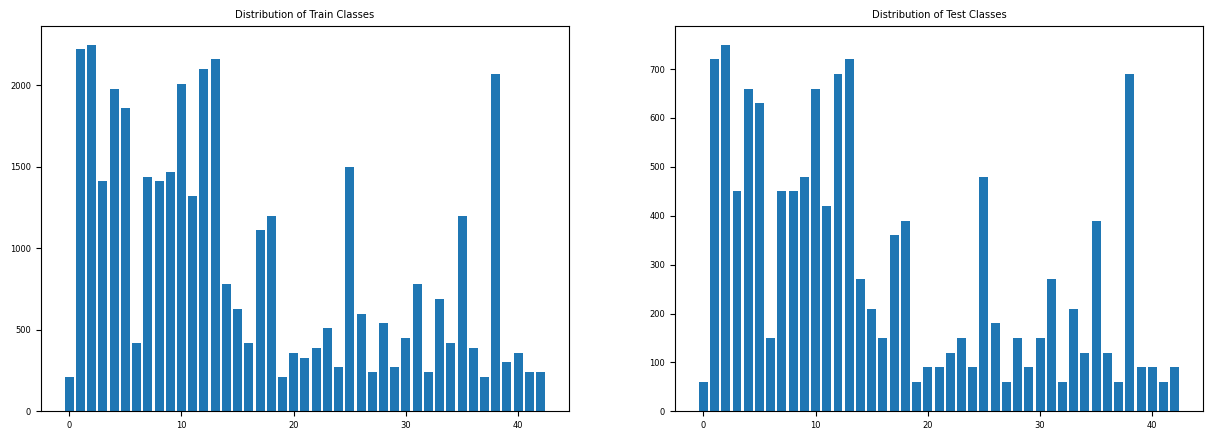

In [7]:
# show the train and test class ids in two separate bar graphs
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(np.unique(train_class_id), np.bincount(train_class_id))
plt.title("Distribution of Train Classes")
plt.subplot(1, 2, 2)
plt.bar(np.unique(test_class_id), np.bincount(test_class_id))
plt.title("Distribution of Test Classes")

In [8]:
# show the count of train and test class counts
print(np.bincount(train_class_id))

print(np.bincount(test_class_id))

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160
  780  630  420 1110 1200  210  360  330  390  510  270 1500  600  240
  540  270  450  780  240  689  420 1200  390  210 2070  300  360  240
  240]
[ 60 720 750 450 660 630 150 450 450 480 660 420 690 720 270 210 150 360
 390  60  90  90 120 150  90 480 180  60 150  90 150 270  60 210 120 390
 120  60 690  90  90  60  90]


#### Observation
- Based on the above bin counts, the minimum count of the 43 classes is 210 for the train dataset.  We will choose a ramdon set of 200 images from each class to set up a sample train dataset for our project.  This uniform sampling will ensure a balanced training dataset. The new train dataset will have 8600 images

- Based on the above bin counts, the minimum count of the classes is 60 for the test dataset.  We will choose a randome set of 60 images from each class to set up a sample test dataset.  The new test dataset will have 2580 images.

In [9]:
# random shuffle the train and test class ids and image paths
train_image_path, train_class_id = sklearn.utils.shuffle(
    train_image_path, train_class_id, random_state=42
)

test_image_path, test_class_id = sklearn.utils.shuffle(
    test_image_path, test_class_id, random_state=42
)

In [10]:
# choose a random set of 200 images of each class from the train set
random_sample_size_train = 200
random_sample_size_test = 60


# define a function to choose a random set of images from the train and test set
def random_sample(image_path, class_id, random_sample_size):
    random_image_path = []
    random_class_id = []
    for i in tqdm(range(len(unique_class_id))):
        count = 0
        for j in range(len(class_id)):
            if unique_class_id[i] == class_id[j]:
                random_image_path.append(image_path[j])
                random_class_id.append(class_id[j])
                count += 1
                if count == random_sample_size:
                    break
    return random_image_path, random_class_id


train_image_path_200, train_class_id_200 = random_sample(
    train_image_path, train_class_id, random_sample_size_train
)
test_image_path_60, test_class_id_60 = random_sample(
    test_image_path, test_class_id, random_sample_size_test
)

print("Total number of train images: ", len(train_image_path_200))
print("Total number of train class ids: ", len(train_class_id_200))
print("Total number of test images: ", len(test_image_path_60))
print("Total number of test class ids: ", len(test_class_id_60))

100%|██████████| 43/43 [00:00<00:00, 1918.49it/s]

Total number of train images:  8600
Total number of train class ids:  8600
Total number of test images:  2580
Total number of test class ids:  2580


In [11]:
# use 20% of the train set as the validation set
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    train_image_path_200,
    train_class_id_200,
    test_size=0.2,
    random_state=42,
    stratify=train_class_id_200,
)

# set x_test and y_test to the test set
x_test = test_image_path_60
y_test = test_class_id_60

print("Total number of train images: ", len(x_train))
print("Total number of train class ids: ", len(y_train))
print("Total number of validation images: ", len(x_val))
print("Total number of validation class ids: ", len(y_val))
print("Total number of test images: ", len(x_test))
print("Total number of test class ids: ", len(y_test))

Total number of train images:  6880
Total number of train class ids:  6880
Total number of validation images:  1720
Total number of validation class ids:  1720
Total number of test images:  2580
Total number of test class ids:  2580


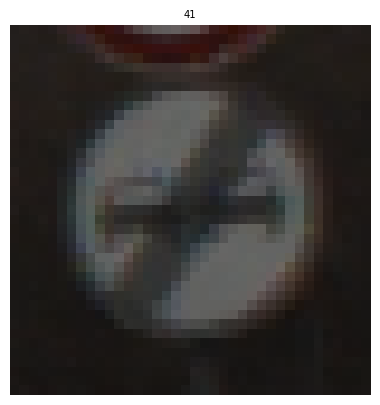

In [12]:
# show one image in the x_val set
plt.imshow(Image.open(x_val[0]))
plt.title(y_val[0])
plt.axis("off")
plt.show()

### Based on the bin count of the images, all classes have more than 200 images.  

- To ensure a balanced dataset, we will choose 200 images from each class to create a new train dataset

### Check the image size of the entire dataset

In [13]:
# get the minimum and maximum size of the images in the train and test data
train_image_size = []
train_classid["Resolution"] = train_classid["Height"] * train_classid["Width"]
print("Minimum size of train image: ")
print(
    train_classid[["Width", "Height", "Resolution"]].loc[
        train_classid["Resolution"] == train_classid["Resolution"].min()
    ]
)
print("")
print("Maximum size of train image: ")
print(
    train_classid[["Width", "Height", "Resolution"]].loc[
        train_classid["Resolution"] == train_classid["Resolution"].max()
    ]
)

test_classid["Resolution"] = test_classid["Height"] * test_classid["Width"]
print("")
print("")
print("Minimum size of test image: ")
print(
    test_classid[["Width", "Height", "Resolution"]].loc[
        test_classid["Resolution"] == test_classid["Resolution"].min()
    ]
)
print("")
print("Maximum size of test image: ")
print(
    test_classid[["Width", "Height", "Resolution"]].loc[
        test_classid["Resolution"] == test_classid["Resolution"].max()
    ]
)

Minimum size of train image: 
       Width  Height  Resolution
3300      25      25         625
6420      25      25         625
18540     25      25         625
20460     25      25         625
24751     25      25         625
34469     25      25         625
35489     25      25         625

Maximum size of train image: 
       Width  Height  Resolution
28589    243     225       54675


Minimum size of test image: 
       Width  Height  Resolution
10062     25      25         625

Maximum size of test image: 
      Width  Height  Resolution
6373    266     232       61712


In [14]:
# calculate mean and median of the train and test image sizes
print(
    "Mean of train image size: \n",
    train_classid[["Width", "Height", "Resolution"]].mean(),
)
print(
    "Median of train image size: \n",
    train_classid[["Width", "Height", "Resolution"]].median(),
)
print("")
print("")
print(
    "Mean of test image size: \n",
    test_classid[["Width", "Height", "Resolution"]].mean(),
)
print(
    "Median of test image size: \n",
    test_classid[["Width", "Height", "Resolution"]].median(),
)

Mean of train image size: 
 Width           50.835880
Height          50.328930
Resolution    3109.825525
dtype: float64
Median of train image size: 
 Width           43.0
Height          43.0
Resolution    1849.0
dtype: float64


Mean of test image size: 
 Width           50.507759
Height          50.364450
Resolution    3125.009976
dtype: float64
Median of test image size: 
 Width           43.0
Height          43.0
Resolution    1845.0
dtype: float64


In [15]:
# The standard image size for VGG16 and VGG19 Resnet is 224 x 224

std_img_size = (224, 224)

### Data Preprocessing



2023-10-16 04:48:50.404450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 04:48:50.409674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 04:48:50.409933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 04:48:50.411403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 04:48:50.411652: I tensorflow/compile

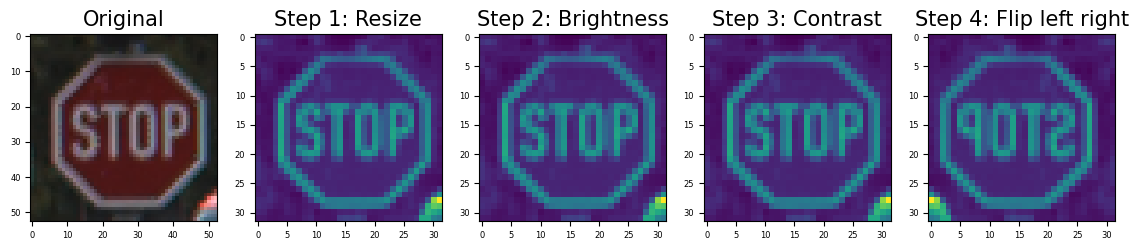

In [16]:
# use one example to explore the image transformation and augmentation techniques
#################################################################################

tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = load_img(train_image_path[900])

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(image)
ax.set_title("Original", size=15)

# test the image transformation
img_io = tf.io.read_file(train_image_path[900])

# # 2. Decode and convert to grayscale
img_io = tf.io.decode_png(img_io, channels=1)

# 3. Convert to float32 in [0, 1] range
img_io = tf.image.convert_image_dtype(img_io, tf.float32)

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(img_io, size=(32, 32))
ax.imshow(array_to_img(img_resize))
ax.set_title("Step 1: Resize", size=15)

# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title("Step 2: Brightness", size=15)


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title("Step 3: Contrast", size=15)


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title("Step 4: Flip left right", size=15);

### Define a distoration free function to standardize the image size with padding

In [18]:
# Resizing images without distortion

# resize the images to the std_img_size
img_size = std_img_size


def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # add the same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    # To improve the model accuracy, use the following techniques to
    # adjust brightness, adjust contrast, transpose and flip the images
    image = tf.image.adjust_brightness(image, 0.3)
    image = tf.image.adjust_contrast(image, contrast_factor=3)
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


# define a function to preprocess the images
def apply_distorion_free_process(image_path, img_size):
    resized_image = []
    for i in tqdm(range(len(image_path))):
        image = tf.keras.preprocessing.image.load_img(image_path[i])
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = distortion_free_resize(image, img_size)
        resized_image.append(image)
    resized_image_np = np.array(resized_image)

    return resized_image, resized_image_np

In [19]:
# apply the distortion free process to the train, validation and test set
x_train_new, x_train_np = apply_distorion_free_process(x_train, img_size)


# print the shape of the train, validation and test set
print("Shape of train set: ", x_train_np.shape)

100%|██████████| 6880/6880 [01:19<00:00, 86.63it/s]


Shape of train set:  (6880, 224, 224, 3)


In [20]:
x_val_new, x_val_np = apply_distorion_free_process(x_val, img_size)
x_test_new, x_test_np = apply_distorion_free_process(x_test, img_size)

print("Shape of validation set: ", x_val_np.shape)
print("Shape of test set: ", x_test_np.shape)

100%|██████████| 2580/2580 [00:28<00:00, 90.89it/s]


Shape of validation set:  (1720, 224, 224, 3)
Shape of test set:  (2580, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


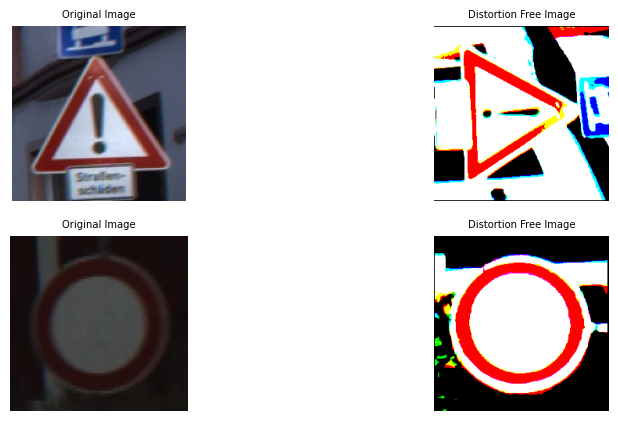

In [21]:
# show 2 images in the train set and compare side by side to the new distortion free images
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(Image.open(x_train[25]))
plt.title("Original Image")
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(x_train_np[25])
plt.title("Distortion Free Image")
plt.axis("off")
plt.subplot(2, 2, 3)
plt.imshow(Image.open(x_train[100]))
plt.title("Original Image")
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(x_train_np[100])
plt.title("Distortion Free Image")
plt.axis("off")
plt.show()

### Feature Extraction

In [22]:
# Average Pixel Color


# define a function to calculate the average pixel color of the images
def average_pixel_color(image_path):
    avg_pixel_color = []
    for i in tqdm(range(len(image_path))):
        image = tf.keras.preprocessing.image.load_img(image_path[i])
        image = tf.keras.preprocessing.image.img_to_array(image)
        avg_pixel_color.append(np.mean(image, axis=(0, 1)))
    return avg_pixel_color


# calculate the average pixel color of the train, validation and test set
avg_pixel_color_train = average_pixel_color(x_train)
avg_pixel_color_val = average_pixel_color(x_val)
avg_pixel_color_test = average_pixel_color(x_test)

100%|██████████| 2580/2580 [00:07<00:00, 341.87it/s]


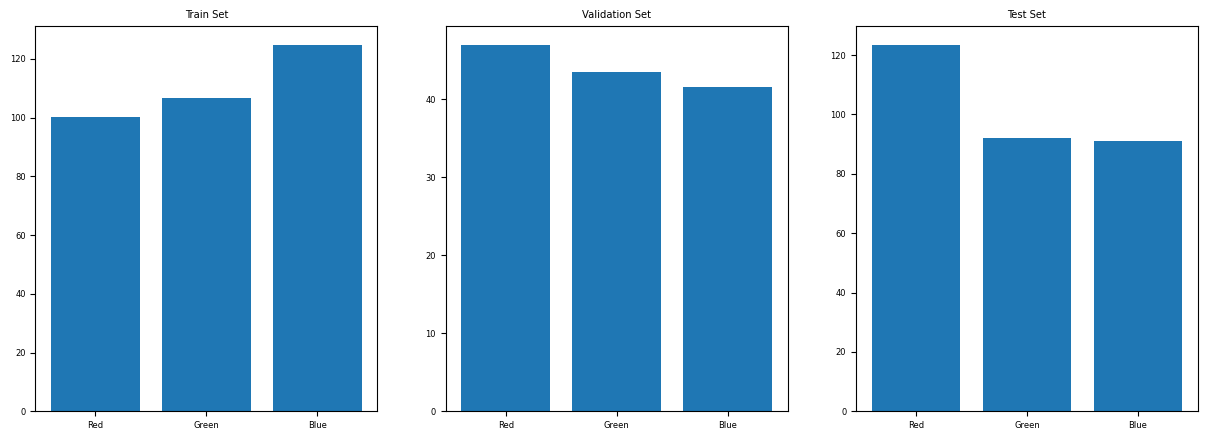

In [23]:
# calculate the average pixel color of the distortion free train, validation and test set for each channel
avg_pixel_color_train_np = np.mean(x_train_np, axis=(1, 2))
avg_pixel_color_val_np = np.mean(x_val_np, axis=(1, 2))
avg_pixel_color_test_np = np.mean(x_test_np, axis=(1, 2))

# plot the average pixel color of the train, validation and test set for each channel
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(np.arange(3), avg_pixel_color_train_np[0])
plt.title("Train Set")
plt.xticks(np.arange(3), ["Red", "Green", "Blue"])
plt.subplot(1, 3, 2)
plt.bar(np.arange(3), avg_pixel_color_val_np[0])
plt.title("Validation Set")
plt.xticks(np.arange(3), ["Red", "Green", "Blue"])
plt.subplot(1, 3, 3)
plt.bar(np.arange(3), avg_pixel_color_test_np[0])
plt.title("Test Set")
plt.xticks(np.arange(3), ["Red", "Green", "Blue"])
plt.show()

In [24]:
# calculate the average pixel color of each class id in the distortion free train set
avg_pixel_color_train_class = []
for i in tqdm(range(len(unique_class_id))):
    avg_pixel_color_train_class.append(
        np.mean(
            x_train_np[np.where(np.array(y_train) == unique_class_id[i])[0].tolist()],
            axis=(0, 1, 2),
        )
    )

100%|██████████| 43/43 [00:05<00:00,  8.19it/s]


In [25]:
len(avg_pixel_color_train_class)

43

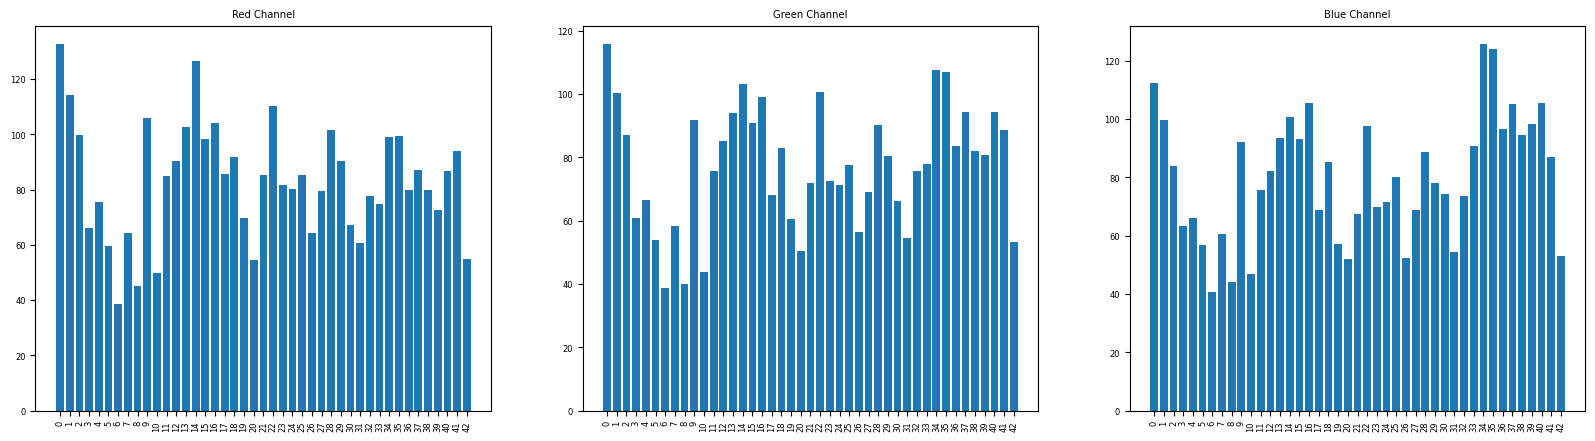

In [26]:
# plot the red channel average pixel color of each class id in the distortion free train set
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.bar(np.arange(43), np.array(avg_pixel_color_train_class)[:, 0])
plt.title("Red Channel")
plt.xticks(np.arange(43), unique_class_id, rotation=90)
plt.subplot(1, 3, 2)
plt.bar(np.arange(43), np.array(avg_pixel_color_train_class)[:, 1])
plt.title("Green Channel")
plt.xticks(np.arange(43), unique_class_id, rotation=90)
plt.subplot(1, 3, 3)
plt.bar(np.arange(43), np.array(avg_pixel_color_train_class)[:, 2])
plt.title("Blue Channel")
plt.xticks(np.arange(43), unique_class_id, rotation=90)
plt.show()